In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Pulse pressure.csv')
data = data.drop(columns=['ap_lo', 'pulse_pressure'])
data.head()


,gender,height,weight,ap_hi,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_category_encoded
0,1,0.463125,-0.873002,-1.043394,1,1,0,0,1,0,-0.412905,2
1,0,-1.107092,0.933963,0.965018,3,1,0,0,1,1,0.325344,3
2,0,0.070571,-0.715875,0.295547,3,1,0,0,0,1,-0.265255,2
3,1,0.593977,0.698272,1.634488,1,1,0,0,1,1,-0.708204,3
4,0,-1.107092,-1.344384,-1.712865,1,1,0,0,0,0,-0.855854,0


Data splitting

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['cardio'])  # Drop the target column
y = data['cardio']  # Keep only the target column

# 60/20/20 train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify = y, random_state=4240)  # 60% train, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp, random_state=4240)  # 20% val, 20% test

print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)

Train Shape: (39411, 11)
Validation Shape: (13137, 11)
Test Shape: (13138, 11)


Correlation of numerical features with target

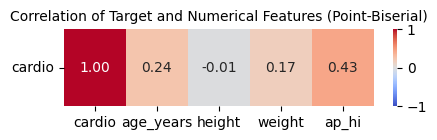

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# List of numerical features, including 'cardio'
numerical_features = ['cardio', 'age_years', 'height', 'weight', 'ap_hi']

# Compute the correlation matrix using the default (Pearson) method
correlation_matrix = data[numerical_features].corr()

# Overwrite the correlations for 'cardio' vs each other numerical variable with point-biserial coefficients
for feature in numerical_features:
    if feature != 'cardio':
        pb_corr = pointbiserialr(data['cardio'], data[feature])[0]
        correlation_matrix.loc['cardio', feature] = pb_corr
        correlation_matrix.loc[feature, 'cardio'] = pb_corr

cardio_corr = correlation_matrix.loc[['cardio']]

# Plot the updated correlation matrix
plt.figure(figsize=(5, 1))
ax = sns.heatmap(cardio_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Target and Numerical Features (Point-Biserial)", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

# Manual Selection
Numerical Drop Height
Categorical drop gender smoke alco

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm


data_manual_model = data.drop(columns=['height', 'gender', 'smoke', 'alco'])

# Train the logistic regression model using scikit-learn on the training set
manual_model = LogisticRegression()
manual_model.fit(X_train, y_train)

# custom threshold
threshold = 0.475

# Evalutate on the training set
train_probs = manual_model.predict_proba(X_train)[:, 1]
manual_y_train_pred = (train_probs >= threshold).astype(int)
print(f"\nTraining Accuracy (threshold = {threshold}):", accuracy_score(y_train, manual_y_train_pred))
print(f"\nTraining Classification Report (threshold = {threshold}):")
print(classification_report(y_train, manual_y_train_pred, digits = 4))

# Evaluate on the validation set
val_probs = manual_model.predict_proba(X_val)[:, 1]
manual_y_val_pred = (val_probs >= threshold).astype(int)
print(f"\nValidation Accuracy (threshold = {threshold}):", accuracy_score(y_val, manual_y_val_pred))
print(f"\nValidation Classification Report (threshold = {threshold}):")
print(classification_report(y_val, manual_y_val_pred, digits = 4))

# Evaluate on the test set
test_probs = manual_model.predict_proba(X_test)[:, 1]
manual_y_test_pred = (test_probs >= threshold).astype(int)
print(f"\nTest Accuracy (threshold = {threshold}):", accuracy_score(y_test, manual_y_test_pred))
print(f"\nTest Classification Report (threshold = {threshold}):")
print(classification_report(y_test, manual_y_test_pred, digits = 4))

# ----- Statsmodels: ANOVA-like table and Odds Ratios on Test Set -----

X_test_manual = X_test.drop(columns=['height', 'gender', 'smoke', 'alco']).reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Add a constant (intercept) term to the test set predictors
X_test_manual_df = sm.add_constant(X_test_manual)

# Fit logistic regression using statsmodels on the test set
logit_model_test = sm.Logit(y_test_reset, X_test_manual_df)
result_test = logit_model_test.fit()

# Print the detailed summary for the test set (ANOVA-like table)
print("\n=== Test Set ANOVA Table (Manual Selection) ===")
print(result_test.summary())

# Calculate and print the Odds Ratios for the test set
odds_ratios_test = pd.Series(np.exp(result_test.params), index=X_test_manual_df.columns)
print("\n=== Test Set Odds Ratios ===")
print(odds_ratios_test)



Training Accuracy (threshold = 0.475): 0.7273096343660399

Training Classification Report (threshold = 0.475):
              precision    recall  f1-score   support

           0     0.7217    0.7666    0.7435     20314
           1     0.7341    0.6856    0.7090     19097

    accuracy                         0.7273     39411
   macro avg     0.7279    0.7261    0.7262     39411
weighted avg     0.7277    0.7273    0.7268     39411


Validation Accuracy (threshold = 0.475): 0.7224632716754206

Validation Classification Report (threshold = 0.475):
              precision    recall  f1-score   support

           0     0.7165    0.7637    0.7394      6772
           1     0.7297    0.6786    0.7032      6365

    accuracy                         0.7225     13137
   macro avg     0.7231    0.7211    0.7213     13137
weighted avg     0.7229    0.7225    0.7218     13137


Test Accuracy (threshold = 0.475): 0.728954178718222

Test Classification Report (threshold = 0.475):
              p

# Forward Backward Selection

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize Logistic Regression Model
lr = LogisticRegression(solver='liblinear')

sfspp = SFS(lr, 
          k_features=7,             # desired number of features (adjust as needed)
          forward=True,             # start with forward selection
          floating=True,            # allow backward steps (floating)
          scoring='f1',       # use accuracy as the metric
          cv=5)                     # 5-fold cross-validation

# Fit SFS on training data
sfspp.fit(X_train, y_train)

# Get the selected feature names
selected_featurespp = list(sfspp.k_feature_names_)
print("Selected Features (Floating SFS):", selected_featurespp)

# Subset the datasets based on the selected features
X_train_sel = X_train[selected_featurespp].reset_index(drop=True)
X_val_sel = X_val[selected_featurespp].reset_index(drop=True)
X_test_sel = X_test[selected_featurespp].reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Train logistic regression model using the selected features
lr.fit(X_train_sel, y_train_reset)

# custom threshold
threshold = 0.475

# Evalutate on the training set
train_probs = lr.predict_proba(X_train_sel)[:, 1]
sel_y_train_pred = (train_probs >= threshold).astype(int)
print(f"\nTraining Accuracy (threshold = {threshold}):", accuracy_score(y_train_reset, sel_y_train_pred))
print(f"\nTraining Classification Report (threshold = {threshold}):")
print(classification_report(y_train_reset, sel_y_train_pred, digits = 4))

# Evaluate on the validation set
val_probs = lr.predict_proba(X_val_sel)[:, 1]
sel_y_val_pred = (val_probs >= threshold).astype(int)
print(f"\nValidation Accuracy (threshold = {threshold}):", accuracy_score(y_val_reset, sel_y_val_pred))
print(f"\nValidation Classification Report (threshold = {threshold}):")
print(classification_report(y_val_reset, sel_y_val_pred, digits = 4))

# Evaluate on the test set
test_probs = lr.predict_proba(X_test_sel)[:, 1]
sel_y_test_pred = (test_probs >= threshold).astype(int)
print(f"\nTest Accuracy (threshold = {threshold}):", accuracy_score(y_test_reset, sel_y_test_pred))
print(f"\nTest Classification Report (threshold = {threshold}):")
print(classification_report(y_test_reset, sel_y_test_pred, digits = 4))

# Add a constant (intercept) term
X_test_sel_df = sm.add_constant(X_test_sel)

# Fit logistic regression using statsmodels on Test Set
logit_model_test = sm.Logit(y_test_reset, X_test_sel_df)
result_test = logit_model_test.fit()

# Get the detailed summary for Test Set
print("\n=== Test Set ANOVA Table Floating Forward/Backward Selection ===")
print(result_test.summary())

# Calculate Odds Ratios for Test Set
odds_ratios_test = pd.Series(np.exp(result_test.params), index=X_test_sel_df.columns)
print("\n=== Test Set Odds Ratios SEL ===")
print(odds_ratios_test)

Selected Features (Floating SFS): ['gender', 'weight', 'ap_hi', 'cholesterol', 'alco', 'active', 'age_years']

Training Accuracy (threshold = 0.475): 0.7262693156732892

Training Classification Report (threshold = 0.475):
              precision    recall  f1-score   support

           0     0.7203    0.7666    0.7427     20314
           1     0.7335    0.6834    0.7076     19097

    accuracy                         0.7263     39411
   macro avg     0.7269    0.7250    0.7251     39411
weighted avg     0.7267    0.7263    0.7257     39411


Validation Accuracy (threshold = 0.475): 0.7220826672756337

Validation Classification Report (threshold = 0.475):
              precision    recall  f1-score   support

           0     0.7167    0.7621    0.7387      6772
           1     0.7286    0.6795    0.7032      6365

    accuracy                         0.7221     13137
   macro avg     0.7227    0.7208    0.7210     13137
weighted avg     0.7225    0.7221    0.7215     13137


Test Ac

# Lasso Regularisation

grid search

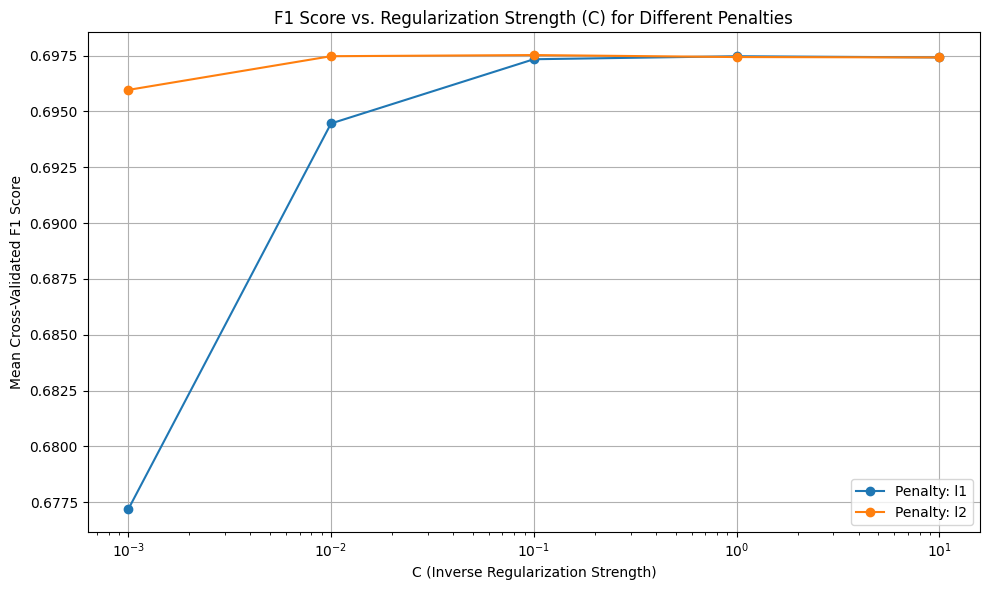

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best F1 score: 0.6975209588083583


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['saga'],
}

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Grid search with F1 scoring
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',  # or 'f1_macro', 'f1_weighted' as needed
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Results DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# ✅ Plot F1 vs. C for each penalty
plt.figure(figsize=(10, 6))
penalties = cv_results['param_penalty'].unique()

for penalty in penalties:
    subset = cv_results[cv_results['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Penalty: {penalty}')

plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Mean Cross-Validated F1 Score')
plt.title('F1 Score vs. Regularization Strength (C) for Different Penalties')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Print best config
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)


In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Set C and threshold
C = 0.1
coef_threshold = 0.01  # Consider only coefficients with abs value > 0.01

# Fit L2-penalized model
model = LogisticRegression(penalty='l2', solver='liblinear', C=C, max_iter=1000)
model.fit(X_train, y_train)

# Get coefficients and features
coef = model.coef_.flatten()
features = X_train.columns

# Identify "important" features (non-trivially weighted)
selected = features[np.abs(coef) > coef_threshold]

# Display result
print("C =", C)
print("Number of Features with |coef| > 0.01:", len(selected))
print("Selected Features:", ', '.join(selected))


C = 0.1
Number of Features with |coef| > 0.01: 9
Selected Features: height, weight, ap_hi, cholesterol, gluc, smoke, alco, active, age_years


In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Fit the L2-regularized logistic regression model
log_model_ridge = LogisticRegression(penalty='l2', solver='saga', C=0.1, max_iter=1000)
log_model_ridge.fit(X_train, y_train)

# Custom threshold
threshold = 0.48

# --- Evaluate on Training Set ---
train_probs = log_model_ridge.predict_proba(X_train)[:, 1]
ridge_y_train_pred = (train_probs >= threshold).astype(int)
print(f"\nTraining Accuracy (threshold = {threshold}):", accuracy_score(y_train, ridge_y_train_pred))
print(f"\nTraining Classification Report (threshold = {threshold}):")
print(classification_report(y_train, ridge_y_train_pred, digits=4))

# --- Evaluate on Validation Set ---
val_probs = log_model_ridge.predict_proba(X_val)[:, 1]
ridge_y_val_pred = (val_probs >= threshold).astype(int)
print(f"\nValidation Accuracy (threshold = {threshold}):", accuracy_score(y_val, ridge_y_val_pred))
print(f"\nValidation Classification Report (threshold = {threshold}):")
print(classification_report(y_val, ridge_y_val_pred, digits=4))

# --- Evaluate on Test Set ---
test_probs = log_model_ridge.predict_proba(X_test)[:, 1]
ridge_y_test_pred = (test_probs >= threshold).astype(int)
print(f"\nTest Accuracy (threshold = {threshold}):", accuracy_score(y_test, ridge_y_test_pred))
print(f"\nTest Classification Report (threshold = {threshold}):")
print(classification_report(y_test, ridge_y_test_pred, digits=4))



Training Accuracy (threshold = 0.48): 0.7265737991931187

Training Classification Report (threshold = 0.48):
              precision    recall  f1-score   support

           0     0.7187    0.7714    0.7441     20314
           1     0.7363    0.6789    0.7064     19097

    accuracy                         0.7266     39411
   macro avg     0.7275    0.7251    0.7253     39411
weighted avg     0.7272    0.7266    0.7259     39411


Validation Accuracy (threshold = 0.48): 0.7225393925553779

Validation Classification Report (threshold = 0.48):
              precision    recall  f1-score   support

           0     0.7144    0.7692    0.7408      6772
           1     0.7326    0.6729    0.7015      6365

    accuracy                         0.7225     13137
   macro avg     0.7235    0.7210    0.7212     13137
weighted avg     0.7233    0.7225    0.7218     13137


Test Accuracy (threshold = 0.48): 0.729030293804232

Test Classification Report (threshold = 0.48):
              precisi

In [50]:
# Extract feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_model_ridge.coef_.flatten()
})

# Sort by absolute magnitude (optional, for easier interpretation)
coef_df['|Coefficient|'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='|Coefficient|', ascending=False)

# Display
print(coef_df)


                Feature  Coefficient  |Coefficient|
3                 ap_hi     0.961392       0.961392
4           cholesterol     0.509994       0.509994
9             age_years     0.362418       0.362418
8                active    -0.243025       0.243025
7                  alco    -0.200200       0.200200
2                weight     0.161456       0.161456
6                 smoke    -0.156972       0.156972
5                  gluc    -0.127012       0.127012
1                height    -0.052404       0.052404
10  bp_category_encoded     0.007979       0.007979
0                gender    -0.001932       0.001932
